In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import meshgrid
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

import os
inpath = "./data/Wildfire/input/"   # Path for the input data
impath = "./data/Wildfire/mac/"
immpath = "./plots/Wildfire/mac/"
os.makedirs(impath, exist_ok=True)
os.makedirs(immpath, exist_ok=True)

# 1D Wildlandfire example

In [2]:
Q_wf = np.load(inpath + 'SnapShotMatrix558.49.npy', allow_pickle=True)
t = np.load(inpath + 'Time.npy', allow_pickle=True)
x_grid = np.load(inpath + '1D_Grid.npy', allow_pickle=True)
x = x_grid[0]
T = Q_wf[:len(x), :]
seed = 420

In [3]:
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
Q = torch.tensor(T/T.max())

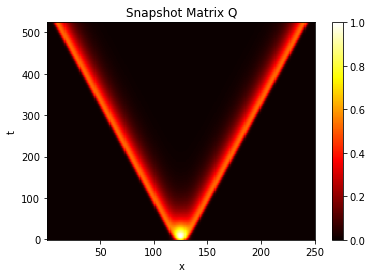

In [5]:
Nx = len(x)
Nt = len(t)
xx, tt = np.meshgrid(x, t)


plt.pcolormesh(xx.T, tt.T, Q, cmap='hot')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("t")
plt.title('Snapshot Matrix Q')
plt.show()

## Define inputs

In [6]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

## Define a model

In [7]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=False)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag((s > 0).to(dtype)[:rank])
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output.unsqueeze(-1).unsqueeze(-1)

In [8]:
class ShapeShiftNet(nn.Module):
    def __init__(self):
        super(ShapeShiftNet, self).__init__()
        
        self.elu = nn.ELU()
        
        # Subnetwork for f^1 and shift^1
        self.f1_fc1 = nn.Linear(2, 5)
        self.f1_fc2 = nn.Linear(5, 10)
        self.f1_fc3 = nn.Linear(10, 5)
        self.f1_fc4 = nn.Linear(5, 1)
        
        self.shift1_fc1 = nn.Linear(1, 5)
        self.shift1_fc2 = nn.Linear(5, 5)
        self.shift1_fc3 = nn.Linear(5, 1)

        
        # Subnetwork for f^2 and shift^2
        self.f2_fc1 = nn.Linear(2, 5)
        self.f2_fc2 = nn.Linear(5, 10)
        self.f2_fc3 = nn.Linear(10, 5)
        self.f2_fc4 = nn.Linear(5, 1)
        
        self.shift2_fc1 = nn.Linear(1, 5)
        self.shift2_fc2 = nn.Linear(5, 5)
        self.shift2_fc3 = nn.Linear(5, 1)
        
        
        # Subnetwork for f^3 and shift^3
        self.f3_fc1 = nn.Linear(2, 5)
        self.f3_fc2 = nn.Linear(5, 10)
        self.f3_fc3 = nn.Linear(10, 5)
        self.f3_fc4 = nn.Linear(5, 1)
        
        self.shift3_fc1 = nn.Linear(1, 5)
        self.shift3_fc2 = nn.Linear(5, 5)
        self.shift3_fc3 = nn.Linear(5, 1)
        
        
    def forward(self, x, t):
        # Pathway for f^1 and shift^1
        shift1 = self.elu(self.shift1_fc1(t))
        shift1 = self.elu(self.shift1_fc2(shift1))
        shift1 = self.shift1_fc3(shift1)
        
        x_shifted1 = x + shift1
        f1 = self.elu(self.f1_fc1(torch.cat((x_shifted1, t), dim=1)))
        f1 = self.elu(self.f1_fc2(f1))
        f1 = self.elu(self.f1_fc3(f1))
        f1 = self.f1_fc4(f1)
        
        f1_without_shift = self.elu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f1_without_shift = self.elu(self.f1_fc2(f1_without_shift))
        f1_without_shift = self.elu(self.f1_fc3(f1_without_shift))
        f1_without_shift = self.f1_fc4(f1_without_shift)
        
        
        # Pathway for f^2 and shift^2
        shift2 = self.elu(self.shift2_fc1(t))
        shift2 = self.elu(self.shift2_fc2(shift2))
        shift2 = self.shift2_fc3(shift2)
        
        x_shifted2 = x + shift2
        f2 = self.elu(self.f2_fc1(torch.cat((x_shifted2, t), dim=1)))
        f2 = self.elu(self.f2_fc2(f2))
        f2 = self.elu(self.f2_fc3(f2))
        f2 = self.f2_fc4(f2)
        
        f2_without_shift = self.elu(self.f2_fc1(torch.cat((x, t), dim=1)))
        f2_without_shift = self.elu(self.f2_fc2(f2_without_shift))
        f2_without_shift = self.elu(self.f2_fc3(f2_without_shift))
        f2_without_shift = self.f2_fc4(f2_without_shift)
        
        
        # Pathway for f^3 and shift^3      
        shift3 = self.elu(self.shift3_fc1(t))
        shift3 = self.elu(self.shift3_fc2(shift3))
        shift3 = self.shift3_fc3(shift3)
        
        x_shifted3 = x + shift3
        f3 = self.elu(self.f3_fc1(torch.cat((x_shifted3, t), dim=1)))
        f3 = self.elu(self.f3_fc2(f3))
        f3 = self.elu(self.f3_fc3(f3))
        f3 = self.f3_fc4(f3)
        
        
        f3_without_shift = self.elu(self.f3_fc1(torch.cat((x, t), dim=1)))
        f3_without_shift = self.elu(self.f3_fc2(f3_without_shift))
        f3_without_shift = self.elu(self.f3_fc3(f3_without_shift))
        f3_without_shift = self.f3_fc4(f3_without_shift)
        
        return f1, f2, f3, f1_without_shift, f2_without_shift, f3_without_shift, shift1, shift2, shift3


In [9]:
def save_fig(filepath, figure=None, **kwargs):
    import tikzplotlib
    import os
    import matplotlib.pyplot as plt

    ## split extension
    fpath = os.path.splitext(filepath)[0]
    ## get figure handle
    if figure is None:
        figure = plt.gcf()
    figure.savefig(fpath + ".png", dpi=300, transparent=True)
    tikzplotlib.save(
        figure=figure,
        filepath=fpath + ".tex",
        axis_height='\\figureheight',
        axis_width='\\figurewidth',
        override_externals=True,
        **kwargs
    )

In [10]:
model = ShapeShiftNet()

pretrained_load = False
if pretrained_load:
    state_dict_original = torch.load("")
    state_dict_new = model.state_dict()
    
    for name, param in state_dict_original.items():
        if name in state_dict_new:
            state_dict_new[name].copy_(param)
            
    model.load_state_dict(state_dict_new, strict=False)
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
num_epochs = 500
lambda_k = 0.1

for epoch in range(num_epochs + 1):
    x_NN, t_NN = inputs_tensor[:, 0:1], inputs_tensor[:, 1:2]
    
    optimizer.zero_grad()
    f1_full, f2_full, f3_full, f1_full_nos, f2_full_nos, f3_full_nos, s1, s2, s3 = model(x_NN,t_NN)
    
    frobenius_loss = torch.norm(Q - f1_full.view(Nx, Nt) - f2_full.view(Nx, Nt) - f3_full.view(Nx, Nt),  'fro') ** 2
    
    nuclear_loss_q1 = NuclearNormAutograd.apply(f1_full_nos.view(Nx, Nt)) 
    nuclear_loss_q2 = NuclearNormAutograd.apply(f2_full_nos.view(Nx, Nt))
    nuclear_loss_q3 = NuclearNormAutograd.apply(f3_full_nos.view(Nx, Nt))
    nuclear_loss = lambda_k * (nuclear_loss_q1 + nuclear_loss_q2 + nuclear_loss_q3)
    
    total_loss = nuclear_loss + frobenius_loss
    
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    if frobenius_loss < 1.0:
        print("Early stopping is triggered")
        break
    
    if epoch % 100 == 0:
        print(
            f'Epoch {epoch}/{num_epochs}, Frob Loss: {frobenius_loss.item()}, Nuclear Loss: {nuclear_loss.item()}, Total loss: {total_loss.item()},')

Epoch 0/500, Frob Loss: 1231453.3591288184, Nuclear Loss: 759.5230712890625, Total loss: 1232212.8822001074,
Epoch 100/500, Frob Loss: 154551.92728018537, Nuclear Loss: 779.8068237304688, Total loss: 155331.73410391583,
Epoch 200/500, Frob Loss: 69665.21762803134, Nuclear Loss: 769.1295776367188, Total loss: 70434.34720566806,
Epoch 300/500, Frob Loss: 39925.17241673704, Nuclear Loss: 762.4158325195312, Total loss: 40687.58824925657,
Epoch 400/500, Frob Loss: 25979.817748673224, Nuclear Loss: 757.9523315429688, Total loss: 26737.770080216193,
Epoch 500/500, Frob Loss: 17526.41448107585, Nuclear Loss: 754.6061401367188, Total loss: 18281.02062121257,


In [12]:
combined = f1_full + f2_full + f3_full
Q_tilde = combined.view(Nx, Nt).detach().numpy()

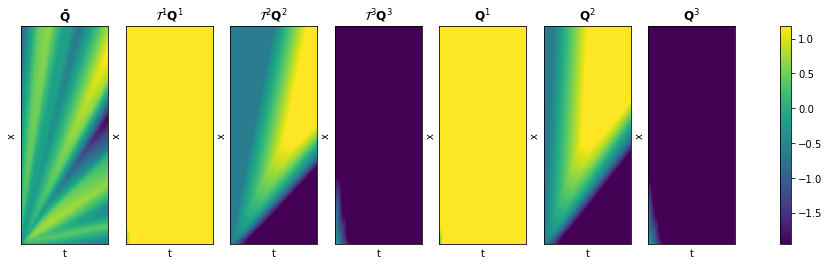

In [13]:
fig, axs = plt.subplots(1, 7, figsize=(16, 4))
vmin = np.min(Q_tilde)
vmax = np.max(Q_tilde)

#Qtilde
axs[0].pcolormesh(xx.T, tt.T, Q_tilde, vmin=vmin, vmax=vmax)
axs[0].set_title(r"$\mathbf{\tilde{Q}}$")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
axs[0].set_xticks([])
axs[0].set_yticks([])

# f^1
axs[1].pcolormesh(xx.T, tt.T, f1_full.view(Nx, Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[1].set_title(r"$\mathcal{T}^1\mathbf{Q}^1$")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
axs[1].set_xticks([])
axs[1].set_yticks([])

# f^3
axs[2].pcolormesh(xx.T, tt.T, f3_full.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[2].set_title(r"$\mathcal{T}^2\mathbf{Q}^2$")
axs[2].set_xlabel("t")
axs[2].set_ylabel("x")
axs[2].set_xticks([])
axs[2].set_yticks([])

# f^2
axs[3].pcolormesh(xx.T, tt.T, f2_full.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[3].set_title(r"$\mathcal{T}^3\mathbf{Q}^3$")
axs[3].set_xlabel("t")
axs[3].set_ylabel("x")
axs[3].set_xticks([])
axs[3].set_yticks([])


# f^1
axs[4].pcolormesh(xx.T, tt.T, f1_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[4].set_title(r"$\mathbf{Q}^1$")
axs[4].set_xlabel("t")
axs[4].set_ylabel("x")
axs[4].set_xticks([])
axs[4].set_yticks([])

# f^3
axs[5].pcolormesh(xx.T, tt.T, f3_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[5].set_title(r"$\mathbf{Q}^2$")
axs[5].set_xlabel("t")
axs[5].set_ylabel("x")
axs[5].set_xticks([])
axs[5].set_yticks([])

# f^2
cax4 = axs[6].pcolormesh(xx.T, tt.T, f2_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[6].set_title(r"$\mathbf{Q}^3$")
axs[6].set_xlabel("t")
axs[6].set_ylabel("x")
axs[6].set_xticks([])
axs[6].set_yticks([])

plt.colorbar(cax4, ax=axs.ravel().tolist(), orientation='vertical')

In [14]:
save_fig(filepath=immpath + "Wildfire_NN", figure=fig)

## Saving the results

In [15]:
torch.save(model.state_dict(), impath + 'Wildfire.pth')
np.save(impath + 'Q.npy', Q)
np.save(impath + 'Q_tilde.npy', Q_tilde)
np.save(impath + 'T1Q1.npy', f1_full.view(Nx, Nt).detach().numpy())
np.save(impath + 'T3Q3.npy', f2_full.view(Nx, Nt).detach().numpy())
np.save(impath + 'T2Q2.npy', f3_full.view(Nx, Nt).detach().numpy())
np.save(impath + 'Q1.npy', f1_full_nos.view(Nx, Nt).detach().numpy())
np.save(impath + 'Q3.npy', f2_full_nos.view(Nx, Nt).detach().numpy())
np.save(impath + 'Q2.npy', f3_full_nos.view(Nx, Nt).detach().numpy())
np.save(impath + 'shifts1.npy', s1.detach().numpy()[:Nt]) 
np.save(impath + 'shifts2.npy', s2.detach().numpy()[:Nt]) 

# Apply rsPOD taking the results from the above as initial guesses

In [16]:
import sys

sys.path.append("./sPOD/lib/")

import numpy as np
from numpy import meshgrid
import matplotlib.pyplot as plt
from sPOD_algo import (
    shifted_POD,
    sPOD_Param,
    give_interpolation_error,
)
from transforms import Transform
from plot_utils import save_fig

In [17]:
# Load the data
Q = np.load(impath + 'Q.npy')
Q_tilde = np.load(impath + 'Q_tilde.npy')
T1Q1 = np.load(impath + 'T1Q1.npy')
T2Q2 = np.load(impath + 'T2Q2.npy')
T3Q3 = np.load(impath + 'T3Q3.npy')
Q1 = np.load(impath + 'Q1.npy')
Q2 = np.load(impath + 'Q2.npy')
Q3 = np.load(impath + 'Q3.npy')
shifts1 = np.load(impath + 'shifts1.npy')
shifts2 = np.load(impath + 'shifts2.npy') 

In [18]:
err = np.linalg.norm(Q - Q_tilde) / np.linalg.norm(Q)
print("NN prediction error: %1.2e " % err)

NN prediction error: 3.38e+00 


In [19]:
# Prepare the transformations
L = x[-1]
dx = x[1] - x[0]
s1 = shifts1[:, 0]
s2 = np.zeros_like(s1)
s3 = shifts2[:, 0]

data_shape = [Nx, 1, 1, Nt]
transfos = [
    Transform(data_shape, [L], shifts=s1, dx=[dx], interp_order=5),
    Transform(data_shape, [L], shifts=s2, dx=[dx], interp_order=5),
    Transform(data_shape, [L], shifts=s3, dx=[dx], interp_order=5),
]

interp_err = np.max([give_interpolation_error(Q, trafo) for trafo in transfos])
print("interpolation error: %1.2e " % interp_err)

Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
interpolation error: 1.01e-03 


In [20]:
METHOD = "ALM"

# Parameters
mu0 = Nx * Nt / (4 * np.sum(np.abs(Q)))
lambd0 = 4000
myparams = sPOD_Param()
myparams.maxit = 10
param_alm = mu0 * 0.01 # adjust for case

In [21]:
# Call the ALM method
ret = shifted_POD(Q, transfos, [1, 1, 1], myparams, METHOD, param_alm, [Q1, Q2, Q3])

Iter    1 / 10 | Rel_err= 2.6728e+00 | norm(dres) = 1.2e-01 | norm(Q-Qtilde)/norm(Q) = 2.67e+00 | t_cpu = 0.00s | ranks_frame =  16 4 15
Iter    2 / 10 | Rel_err= 1.5602e+00 | norm(dres) = 4.9e-02 | norm(Q-Qtilde)/norm(Q) = 1.56e+00 | t_cpu = 0.00s | ranks_frame =  16 3 9
Iter    3 / 10 | Rel_err= 9.1143e-01 | norm(dres) = 2.8e-02 | norm(Q-Qtilde)/norm(Q) = 9.11e-01 | t_cpu = 0.00s | ranks_frame =  7 3 6
Iter    4 / 10 | Rel_err= 7.2938e-01 | norm(dres) = 8.0e-03 | norm(Q-Qtilde)/norm(Q) = 7.29e-01 | t_cpu = 0.00s | ranks_frame =  7 3 5
Iter    5 / 10 | Rel_err= 5.3502e-01 | norm(dres) = 8.5e-03 | norm(Q-Qtilde)/norm(Q) = 5.35e-01 | t_cpu = 0.00s | ranks_frame =  10 5 5
Iter    6 / 10 | Rel_err= 4.0396e-01 | norm(dres) = 5.7e-03 | norm(Q-Qtilde)/norm(Q) = 4.04e-01 | t_cpu = 0.00s | ranks_frame =  10 8 6
Iter    7 / 10 | Rel_err= 3.1642e-01 | norm(dres) = 3.8e-03 | norm(Q-Qtilde)/norm(Q) = 3.16e-01 | t_cpu = 0.00s | ranks_frame =  11 9 6
Iter    8 / 10 | Rel_err= 2.7991e-01 | norm(dres)

In [22]:
sPOD_frames, qtilde, rel_err = ret.frames, ret.data_approx, ret.rel_err_hist
qf = [
    np.squeeze(np.reshape(trafo.apply(frame.build_field()), data_shape))
    for trafo, frame in zip(transfos, ret.frames)
]

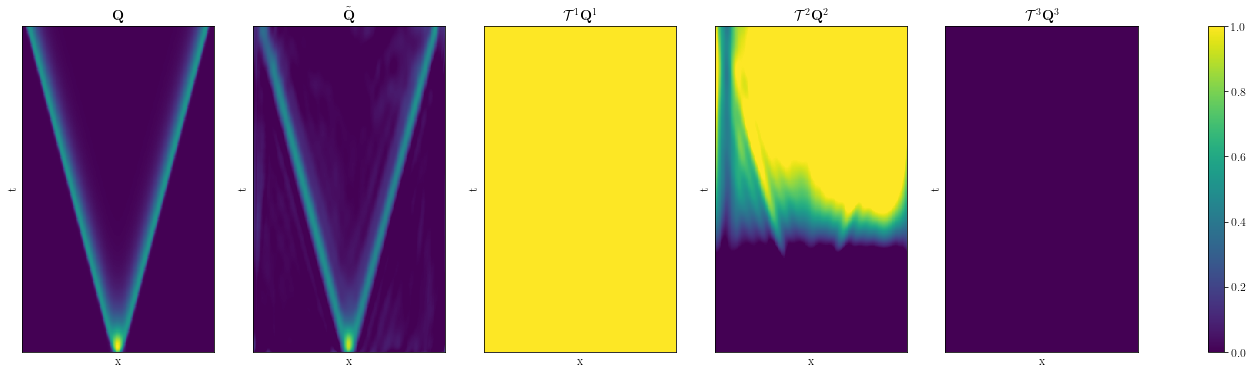

In [23]:
# %% 1. visualize your results: sPOD frames
############################################

fig, axs = plt.subplots(1, 5, figsize=(25, 6))
vmin = np.min(Q)
vmax = np.max(Q)

axs[0].pcolormesh(xx.T, tt.T, Q, vmin=vmin, vmax=vmax)
axs[0].set_title(r"${\mathbf{Q}}$")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
axs[0].set_xticks([])
axs[0].set_yticks([])

#Qtilde
axs[1].pcolormesh(xx.T, tt.T, qtilde, vmin=vmin, vmax=vmax)
axs[1].set_title(r"$\tilde{\mathbf{Q}}$")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
axs[1].set_xticks([])
axs[1].set_yticks([])

# f^1
axs[2].pcolormesh(xx.T, tt.T, qf[0], vmin=vmin, vmax=vmax)
axs[2].set_title(r"$\mathcal{T}^1\mathbf{Q}^1$")
axs[2].set_xlabel("x")
axs[2].set_ylabel("t")
axs[2].set_xticks([])
axs[2].set_yticks([])

# f^2
axs[3].pcolormesh(xx.T, tt.T, qf[1], vmin=vmin, vmax=vmax)
axs[3].set_title(r"$\mathcal{T}^2\mathbf{Q}^2$")
axs[3].set_xlabel("x")
axs[3].set_ylabel("t")
axs[3].set_xticks([])
axs[3].set_yticks([])

# f^3
cax4 = axs[4].pcolormesh(xx.T, tt.T, qf[2], vmin=vmin, vmax=vmax)
axs[4].set_title(r"$\mathcal{T}^3\mathbf{Q}^3$")
axs[4].set_xlabel("x")
axs[4].set_ylabel("t")
axs[4].set_xticks([])
axs[4].set_yticks([])

plt.colorbar(cax4, ax=axs.ravel().tolist(), orientation='vertical')

In [24]:
save_fig(filepath=immpath + "Wildfire_sPOD", figure=fig)